In [1]:
import qcodes as qc
import numpy as np
from qcodes.dataset.plotting import plot_dataset
from time import time, sleep
import tqdm

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/guen/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/guen/.qcodes/logs/211019-26747-qcodes.log


In [2]:
import qsharp
qsharp.packages.add("Microsoft.Quantum.Chemistry")
qsharp.reload()

Preparing Q# environment...


Adding package Microsoft.Quantum.Chemistry.

Reloading workspace.

In [3]:
from Microsoft.Quantum.Samples.Chemistry.SimpleVQE import GetEnergyHydrogenVQE

In [4]:
qc.initialise_or_create_database_at("./experiments.db")
exp = qc.load_or_create_experiment(experiment_name='VQE',
                                sample_name="Q# simulator")

In [5]:
ystart, ystop, ystep = -2., 2., .5
zstart, zstop, zstep = -2., 2., .5
x = 0.0
ydata = np.arange(ystart, ystop+ystep, ystep)
zdata = np.arange(zstart, zstop+zstep, zstep)
n_samples = 10e3

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
meas = qc.Measurement(exp=exp, station=None, name='VQE measurement')
meas.register_custom_parameter("theta1")
meas.register_custom_parameter("theta2")
meas.register_custom_parameter("theta3")
meas.register_custom_parameter("energy", setpoints=("theta2", "theta3"))
meas.write_period = 2 

with meas.run() as datasaver:
    values = [(x, y, z) for y in ydata for z in zdata]
    for theta in tqdm.tqdm(values):
        theta1, theta2, theta3 = theta
        energy = GetEnergyHydrogenVQE(theta1=theta1, theta2=theta2, theta3=theta3, nSamples=n_samples)
        datasaver.add_result(
            ("theta1", theta1),
            ("theta2", theta2),
            ("theta3", theta3),
            ("energy", energy)        
        )
        sleep(0.2)
    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 4. 


100%|███████████████████████████████████████████| 81/81 [00:19<00:00,  4.09it/s]


([<AxesSubplot:title={'center':'Run #4, Experiment VQE (Q# simulator)'}, xlabel='theta2', ylabel='theta3'>],
 [<matplotlib.colorbar.Colorbar at 0x7feacb217790>])

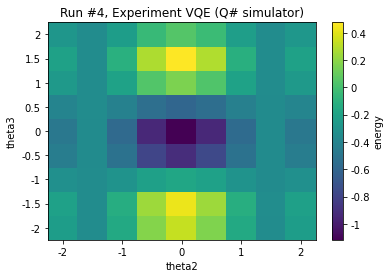

In [6]:
plot_dataset(dataset)

In [7]:
from scipy.optimize import minimize

def VQE(initial_var_params, n_samples, **kwargs):
    """ Run VQE Optimization to find the optimal energy and the associated variational parameters """
    
    # Create the initial parameters (noting that our single qubit variational form has 3 parameters)
    meas = qc.Measurement(exp=exp, station=None, name='VQE measurement')
    meas.register_custom_parameter("time")
    meas.register_custom_parameter("theta1")
    meas.register_custom_parameter("theta2")
    meas.register_custom_parameter("theta3")
    meas.register_custom_parameter("energy", setpoints=("time",))
    meas.write_period = 2 

    time_start = time()
    
    with meas.run() as datasaver:
        def get_data(theta, n_samples):
            theta1, theta2, theta3 = theta
            energy = GetEnergyHydrogenVQE(theta1=theta1, theta2=theta2, theta3=theta3, nSamples=n_samples)
            datasaver.add_result(
                ("time", time() - time_start),
                ("theta1", theta1),
                ("theta2", theta2),
                ("theta3", theta3),
                ("energy", energy)        
            )
            return energy

        opt_result = minimize(get_data,
                              initial_var_params,
                              args=(n_samples),
                              **kwargs)
        dataset = datasaver.dataset  # convenient to have for plotting

    return opt_result, dataset

In [8]:
opt_result, dataset = VQE(initial_var_params=(0.0, -.5, 0.7), n_samples=10000, 
                          method="nelder-mead",
                            options={
                              'maxiter': 200,
                              'maxfev': None,
                              'disp': False,
                              'return_all': False,
                              'initial_simplex': None,
                              'xatol': 0.01,
                              'fatol': 0.01,
                              'adaptive': False
                            })

Starting experimental run with id: 5. 


([<AxesSubplot:title={'center':'Run #5, Experiment VQE (Q# simulator)'}, xlabel='time', ylabel='energy'>],
 [None])

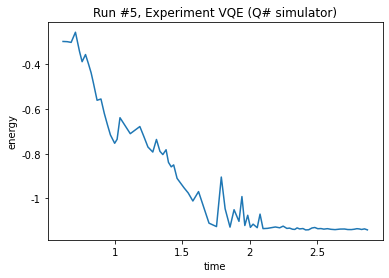

In [9]:
plot_dataset(dataset)

In [10]:
opt_result, dataset = VQE(
    initial_var_params=(0.0, -.5, 0.7),
    n_samples=10000,
    method="COBYLA",
    tol=0.000001,
    options={'disp': True, 'maxiter': 200,'rhobeg' : 0.01}
)

Starting experimental run with id: 6. 

   Normal return from subroutine COBYLA

   NFVALS =   48   F =-3.914827E-01    MAXCV = 0.000000E+00
   X = 1.059883E-02  -5.050520E-01   6.273222E-01


([<AxesSubplot:title={'center':'Run #6, Experiment VQE (Q# simulator)'}, xlabel='time', ylabel='energy'>],
 [None])

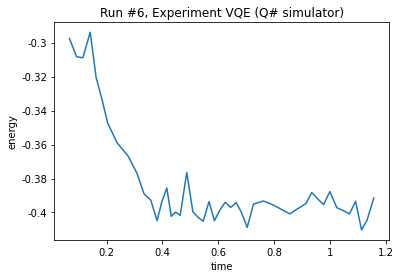

In [11]:
plot_dataset(dataset)

In [12]:
from qcodes.interactive_widget import experiments_widget
experiments_widget()